# Project 1 - Deep learning - Neural network

### Student details:

In [17]:
name = "Gal Halili"
id = 317997039

In [1]:
pip install torch torchvision

     -------------------------------------- 198.5/198.5 MB 2.8 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 3.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, cross_val_score

### Turn data into tensors and create train and test splits

In [3]:
# Define transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data
])

# Load the training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform)

# Load the test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

In [4]:
# Create data loaders to load data in batches during training and testing
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [16]:
print("Training dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Training dataset size: 60000
Test dataset size: 10000


# Exploring the data

In [20]:
# Get the unique labels
train_labels = train_dataset.classes

# Print the unique labels
print("Dataset labels - classes:", train_labels)

Dataset labels - classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


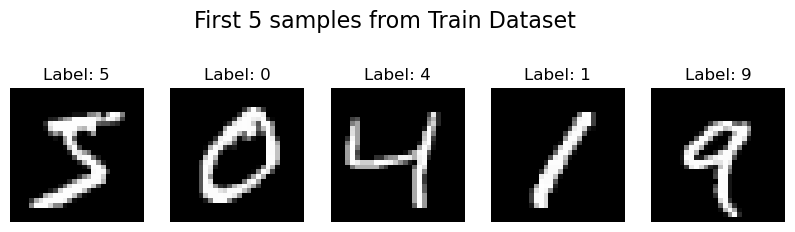

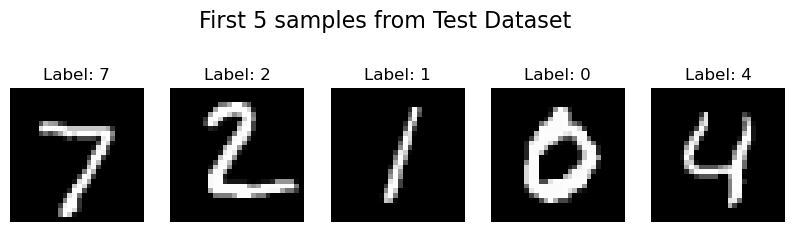

In [34]:
# Function to display the first 5 samples from a dataset
def display_samples(dataset, title):
    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    fig.suptitle(title, fontsize=16)
    
    for i in range(5):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    
    plt.show()

# Display the first 5 samples from the train dataset
display_samples(train_dataset, "First 5 samples from Train Dataset")

# Display the first 5 samples from the test dataset
display_samples(test_dataset, "First 5 samples from Test Dataset")

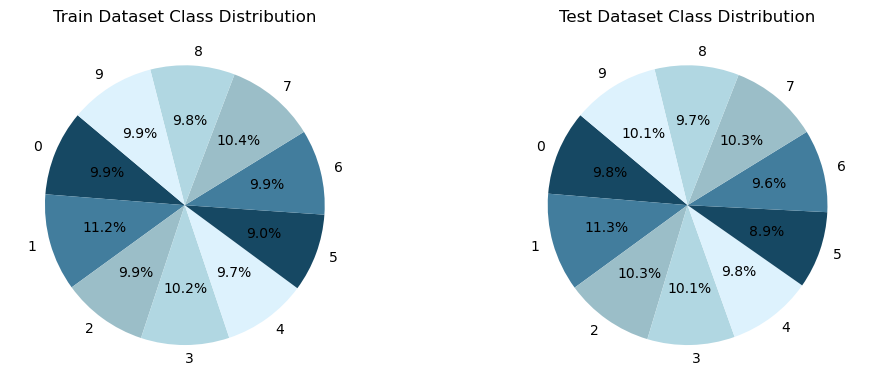

In [45]:
import matplotlib.pyplot as plt

def count_labels(dataset):
    # Get the labels for the dataset as numpy array
    labels = dataset.targets.numpy()

    # Count the occurrences of each label in the dataset
    label_counts = [0] * 10
    for label in labels:
        label_counts[label] += 1 
    
    return label_counts

# Count labels for train and test datasets
train_label_counts = count_labels(train_dataset)
test_label_counts = count_labels(test_dataset)

# Plot the distribution side by side as pie plots
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Plot for train dataset
axes[0].pie(train_label_counts, labels=range(10), autopct='%1.1f%%', startangle=140, colors=['#164863', '#427d9d', '#9bbec8', '#b1d7e2', '#ddf2fd', '#164863', '#427d9d', '#9bbec8', '#b1d7e2', '#ddf2fd'])
axes[0].set_title('Train Dataset Class Distribution')

# Plot for test dataset
axes[1].pie(test_label_counts, labels=range(10), autopct='%1.1f%%', startangle=140, colors=['#164863', '#427d9d', '#9bbec8', '#b1d7e2', '#ddf2fd', '#164863', '#427d9d', '#9bbec8', '#b1d7e2', '#ddf2fd'])
axes[1].set_title('Test Dataset Class Distribution')

plt.tight_layout()
plt.show()

# Building a model and hyperparameter experimentation

#### I will try to find the best size and number of hidden layers

In [6]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size, num_layers, layer_size):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Linear(input_size, layer_size))
            self.layers.append(nn.ReLU())
            input_size = layer_size
        self.fc_out = nn.Linear(layer_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        for layer in self.layers:
            x = layer(x)
        x = self.fc_out(x)
        return x

# Define the hyperparameters grid
param_grid = {
    'num_layers': [1, 2, 3],
    'layer_size': [64, 128, 256]
}

# Perform k-fold cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

best_accuracy = 0
best_hyperparams = None

# Grid search
for params in ParameterGrid(param_grid):
    accuracies = []
    for train_indices, val_indices in k_fold.split(train_dataset):
        # Create data loaders for train and validation sets
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

        # Initialize the model
        input_size = 28 * 28
        output_size = 10
        model = SimpleNN(input_size, output_size, params['num_layers'], params['layer_size'])

        # Define loss function
        criterion = nn.CrossEntropyLoss()

        # Define optimizer
        optimizer = optim.SGD(model.parameters(), lr=0.01)

        # Train the model
        num_epochs = 5
        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        accuracies.append(accuracy)

    # Calculate average accuracy across folds
    avg_accuracy = np.mean(accuracies)

    # Check if this set of hyperparameters gives better accuracy
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_hyperparams = params

print("Best hyperparameters:", best_hyperparams)
print("Best average accuracy:", best_accuracy)

Best hyperparameters: {'layer_size': 256, 'num_layers': 2}
Best average accuracy: 0.91935


#### Now I will check the lr

In [6]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [8]:
# Define the hyperparameters grid
param_grid = {
    'lr': [0.1, 0.01, 0.001]
}

# Perform k-fold cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

best_accuracy = 0
best_hyperparams = None
best_train_losses = None
best_val_losses = None
best_train_accuracies = None
best_val_accuracies = None

# Grid search
for lr in param_grid['lr']:
    train_losses_list = []
    val_losses_list = []
    train_accuracies_list = []
    val_accuracies_list = []

    for train_indices, val_indices in k_fold.split(train_dataset):
        # Create data loaders for train and validation sets
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

        # Initialize the model
        model = SimpleNN()

        # Define loss function
        criterion = nn.CrossEntropyLoss()

        # Define optimizer
        optimizer = optim.SGD(model.parameters(), lr=lr)

        # Train the model
        num_epochs = 50
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(num_epochs):
            model.train()
            running_train_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
            epoch_train_loss = running_train_loss / len(train_indices)
            epoch_train_accuracy = correct_train / total_train
            train_losses.append(epoch_train_loss)
            train_accuracies.append(epoch_train_accuracy)

            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
            epoch_val_loss = running_val_loss / len(val_indices)
            epoch_val_accuracy = correct_val / total_val
            val_losses.append(epoch_val_loss)
            val_accuracies.append(epoch_val_accuracy)

        train_losses_list.append(train_losses)
        val_losses_list.append(val_losses)
        train_accuracies_list.append(train_accuracies)
        val_accuracies_list.append(val_accuracies)

    # Calculate average accuracy across folds
    avg_accuracy = np.mean(val_accuracies_list)

    # Check if this learning rate gives better accuracy
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_hyperparams = {'lr': lr}
        best_train_losses = np.mean(train_losses_list, axis=0)
        best_val_losses = np.mean(val_losses_list, axis=0)
        best_train_accuracies = np.mean(train_accuracies_list, axis=0)
        best_val_accuracies = np.mean(val_accuracies_list, axis=0)

print("Best hyperparameters:", best_hyperparams)
print("Best average accuracy:", best_accuracy)

Best hyperparameters: {'lr': 0.1}
Best average accuracy: 0.9770456666666667


AttributeError: module 'matplotlib' has no attribute 'figure'

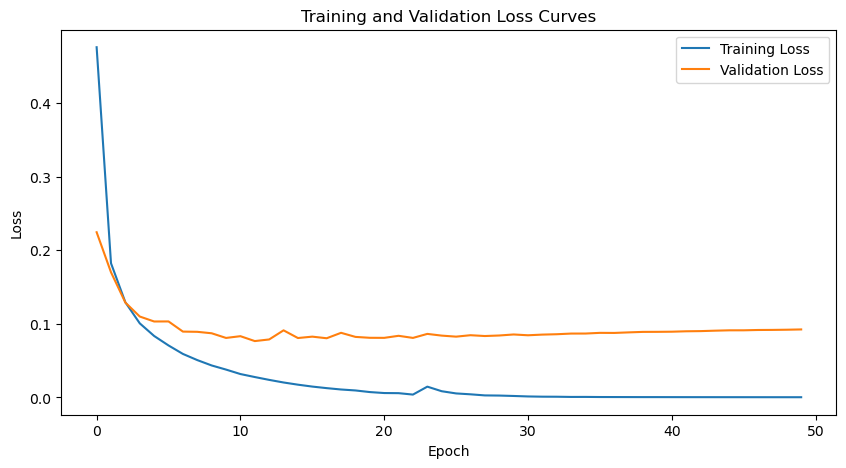

In [11]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(best_train_losses, label='Training Loss')
plt.plot(best_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Search for the best optimizer - GD, SGD, Mini-batch

In [13]:
# Define the hyperparameters grid
param_grid = {
    'optimizer': ['gd', 'sgd', 'mini_batch']
}

# Perform k-fold cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

best_accuracy = 0
best_hyperparams = None

# Grid search
for optimizer_name in param_grid['optimizer']:
    accuracies = []
    for train_indices, val_indices in k_fold.split(train_dataset):
        # Create data loaders for train and validation sets
        train_sampler = SubsetRandomSampler(train_indices)
        val_sampler = SubsetRandomSampler(val_indices)
        train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

        # Initialize the model
        model = SimpleNN()

        # Define loss function
        criterion = nn.CrossEntropyLoss()

        # Define optimizer
        if optimizer_name == 'gd':
            optimizer = optim.SGD(model.parameters(), lr=0.1)
        elif optimizer_name == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        elif optimizer_name == 'mini_batch':
            optimizer = optim.SGD(model.parameters(), lr=0.1)
        else:
            raise ValueError("Invalid optimizer")

        # Train the model
        num_epochs = 50
        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        accuracies.append(accuracy)

    # Calculate average accuracy across folds
    avg_accuracy = np.mean(accuracies)

    # Check if this optimizer gives better accuracy
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_hyperparams = {'optimizer': optimizer_name}

print("Best hyperparameters:", best_hyperparams)
print("Best average accuracy:", best_accuracy)

Best hyperparameters: {'optimizer': 'gd'}
Best average accuracy: 0.9813833333333333


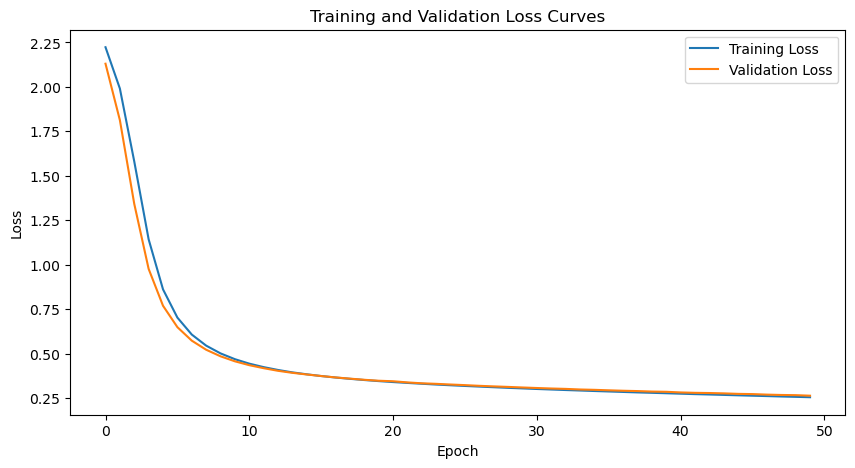

In [14]:
# Plot the loss curves for both training and validation sets
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Overfitting Prevention:

### I will use dropout and early stopping 

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:02<00:00, 3825707.81it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 2733514.47it/s]

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 4509814.93it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



Epoch [1/70], Train Loss: 0.4709, Val Loss: 0.2533
Epoch [2/70], Train Loss: 0.2016, Val Loss: 0.1682
Epoch [3/70], Train Loss: 0.1527, Val Loss: 0.1911
Epoch [4/70], Train Loss: 0.1256, Val Loss: 0.0972
Epoch [5/70], Train Loss: 0.1113, Val Loss: 0.0897
Epoch [6/70], Train Loss: 0.0960, Val Loss: 0.0860
Epoch [7/70], Train Loss: 0.0878, Val Loss: 0.0799
Epoch [8/70], Train Loss: 0.0811, Val Loss: 0.0791
Epoch [9/70], Train Loss: 0.0748, Val Loss: 0.0742
Epoch [10/70], Train Loss: 0.0686, Val Loss: 0.0681
Epoch [11/70], Train Loss: 0.0634, Val Loss: 0.0783
Epoch [12/70], Train Loss: 0.0602, Val Loss: 0.0741
Epoch [13/70], Train Loss: 0.0579, Val Loss: 0.0887
Epoch [14/70], Train Loss: 0.0541, Val Loss: 0.0810
Epoch [15/70], Train Loss: 0.0504, Val Loss: 0.0700
Epoch [16/70], Train Loss: 0.0473, Val Loss: 0.0640
Epoch [17/70], Train Loss: 0.0464, Val Loss: 0.0567
Epoch [18/70], Train Loss: 0.0407, Val Loss: 0.0708
Epoch [19/70], Train Loss: 0.0418, Val Loss: 0.0659
Epoch [20/70], Train 

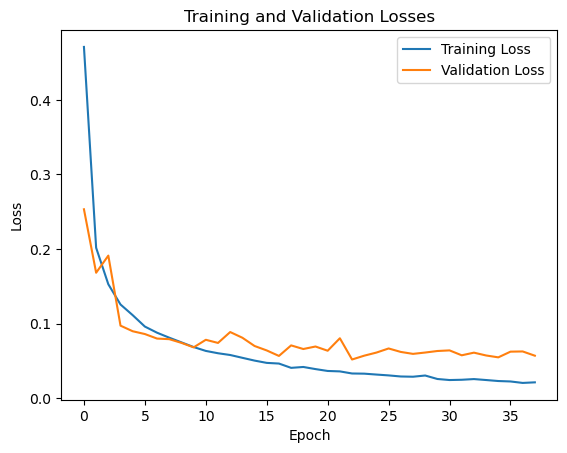

Validation Accuracy: 0.9849


In [26]:
# Define the FCN model with dropout and early stopping
class FCNWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(FCNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST(root='.', train=False, transform=transform)

# Set the hyperparameters
input_size = 28 * 28  # input images of size 28x28
hidden_size = 256  # Number of units in the hidden layers
output_size = 10  # Number of output classes (for classification)
learning_rate = 0.1
dropout_rate = 0.2  # Dropout rate

# Initialize the model
model = FCNWithDropout(input_size, hidden_size, output_size, dropout_rate)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define early stopping parameters
max_epochs = 70
patience = 15
best_val_loss = float('inf')
no_improvement_count = 0
best_model_state = None

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch + 1}/{max_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Check for early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
        best_model_state = model.state_dict()
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f"No improvement for {patience} epochs. Early stopping...")
        break

# Load the best model state
model.load_state_dict(best_model_state)

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

### I see that I have some overfitting so I will try to use Higher dropout rate (p)

Epoch [1/70], Train Loss: 0.5009, Val Loss: 0.2355
Epoch [2/70], Train Loss: 0.2315, Val Loss: 0.1486
Epoch [3/70], Train Loss: 0.1768, Val Loss: 0.1228
Epoch [4/70], Train Loss: 0.1520, Val Loss: 0.1060
Epoch [5/70], Train Loss: 0.1362, Val Loss: 0.1022
Epoch [6/70], Train Loss: 0.1198, Val Loss: 0.1095
Epoch [7/70], Train Loss: 0.1109, Val Loss: 0.0949
Epoch [8/70], Train Loss: 0.1021, Val Loss: 0.0814
Epoch [9/70], Train Loss: 0.0927, Val Loss: 0.0717
Epoch [10/70], Train Loss: 0.0899, Val Loss: 0.0774
Epoch [11/70], Train Loss: 0.0852, Val Loss: 0.0710
Epoch [12/70], Train Loss: 0.0799, Val Loss: 0.0627
Epoch [13/70], Train Loss: 0.0763, Val Loss: 0.0739
Epoch [14/70], Train Loss: 0.0729, Val Loss: 0.0668
Epoch [15/70], Train Loss: 0.0722, Val Loss: 0.0812
Epoch [16/70], Train Loss: 0.0671, Val Loss: 0.0663
Epoch [17/70], Train Loss: 0.0616, Val Loss: 0.0563
Epoch [18/70], Train Loss: 0.0614, Val Loss: 0.0755
Epoch [19/70], Train Loss: 0.0595, Val Loss: 0.0677
Epoch [20/70], Train 

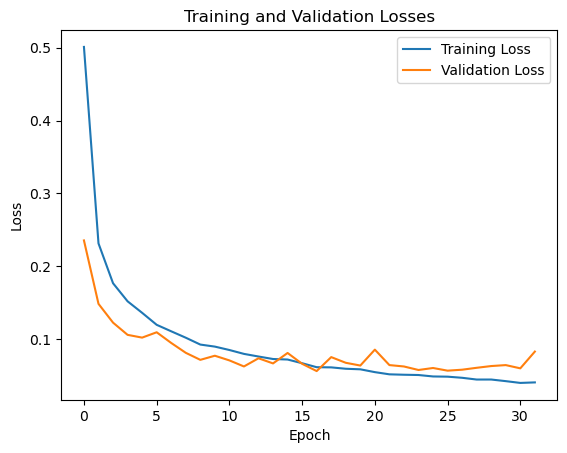

Validation Accuracy: 0.9768


In [27]:
# Define the FCN model with dropout and early stopping
class FCNWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(FCNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='.', train=False, transform=transform)

# Set the hyperparameters
input_size = 28 * 28  # input images of size 28x28
hidden_size = 256  # Number of units in the hidden layers
output_size = 10  # Number of output classes (for classification)
learning_rate = 0.1
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model = FCNWithDropout(input_size, hidden_size, output_size, dropout_rate)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define early stopping parameters
max_epochs = 70
patience = 15
best_val_loss = float('inf')
no_improvement_count = 0
best_model_state = None

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch + 1}/{max_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Check for early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
        best_model_state = model.state_dict()
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f"No improvement for {patience} epochs. Early stopping...")
        break

# Load the best model state
model.load_state_dict(best_model_state)

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

### It helped a little but I will try more dropout rate (p) and number of epochs to wait in early stopping (n) combinations

Epoch [1/70], Train Loss: 0.5120, Val Loss: 0.1920
Epoch [2/70], Train Loss: 0.2371, Val Loss: 0.1754
Epoch [3/70], Train Loss: 0.1827, Val Loss: 0.1269
Epoch [4/70], Train Loss: 0.1556, Val Loss: 0.1198
Epoch [5/70], Train Loss: 0.1378, Val Loss: 0.1190
Epoch [6/70], Train Loss: 0.1200, Val Loss: 0.0853
Epoch [7/70], Train Loss: 0.1118, Val Loss: 0.0823
Epoch [8/70], Train Loss: 0.1048, Val Loss: 0.0884
Epoch [9/70], Train Loss: 0.0964, Val Loss: 0.0823
Epoch [10/70], Train Loss: 0.0928, Val Loss: 0.0728
Epoch [11/70], Train Loss: 0.0868, Val Loss: 0.0797
Epoch [12/70], Train Loss: 0.0798, Val Loss: 0.1175
Epoch [13/70], Train Loss: 0.0803, Val Loss: 0.0712
Epoch [14/70], Train Loss: 0.0741, Val Loss: 0.0700
Epoch [15/70], Train Loss: 0.0688, Val Loss: 0.0718
Epoch [16/70], Train Loss: 0.0689, Val Loss: 0.0659
Epoch [17/70], Train Loss: 0.0622, Val Loss: 0.0761
Epoch [18/70], Train Loss: 0.0625, Val Loss: 0.0629
Epoch [19/70], Train Loss: 0.0601, Val Loss: 0.0667
Epoch [20/70], Train 

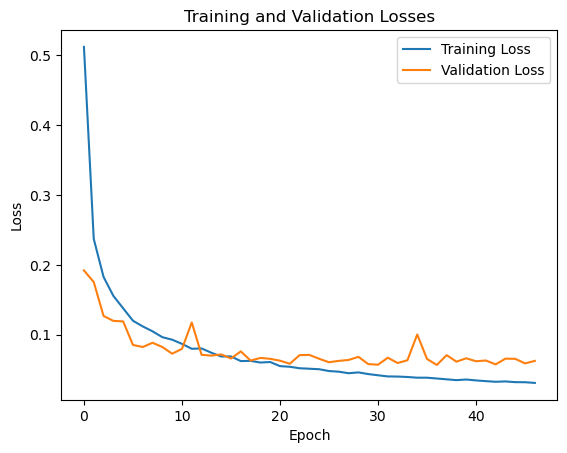

Validation Accuracy: 0.9842


In [28]:
# Define the FCN model with dropout and early stopping
class FCNWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(FCNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='.', train=False, transform=transform)

# Set the hyperparameters
input_size = 28 * 28  # input images of size 28x28
hidden_size = 256  # Number of units in the hidden layers
output_size = 10  # Number of output classes (for classification)
learning_rate = 0.1
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model = FCNWithDropout(input_size, hidden_size, output_size, dropout_rate)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define early stopping parameters
max_epochs = 70
patience = 10
best_val_loss = float('inf')
no_improvement_count = 0
best_model_state = None

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch + 1}/{max_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Check for early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
        best_model_state = model.state_dict()
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f"No improvement for {patience} epochs. Early stopping...")
        break

# Load the best model state
model.load_state_dict(best_model_state)

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch [1/70], Train Loss: 0.5039, Val Loss: 0.1984
Epoch [2/70], Train Loss: 0.2318, Val Loss: 0.1547
Epoch [3/70], Train Loss: 0.1803, Val Loss: 0.1260
Epoch [4/70], Train Loss: 0.1513, Val Loss: 0.0988
Epoch [5/70], Train Loss: 0.1373, Val Loss: 0.1052
Epoch [6/70], Train Loss: 0.1230, Val Loss: 0.1435
Epoch [7/70], Train Loss: 0.1127, Val Loss: 0.1268
Epoch [8/70], Train Loss: 0.1056, Val Loss: 0.0771
Epoch [9/70], Train Loss: 0.0986, Val Loss: 0.0767
Epoch [10/70], Train Loss: 0.0925, Val Loss: 0.0767
Epoch [11/70], Train Loss: 0.0850, Val Loss: 0.0803
Epoch [12/70], Train Loss: 0.0830, Val Loss: 0.0763
Epoch [13/70], Train Loss: 0.0790, Val Loss: 0.1352
Epoch [14/70], Train Loss: 0.0753, Val Loss: 0.0684
Epoch [15/70], Train Loss: 0.0707, Val Loss: 0.0855
Epoch [16/70], Train Loss: 0.0679, Val Loss: 0.0657
Epoch [17/70], Train Loss: 0.0647, Val Loss: 0.0648
Epoch [18/70], Train Loss: 0.0636, Val Loss: 0.0620
Epoch [19/70], Train Loss: 0.0601, Val Loss: 0.0648
Epoch [20/70], Train 

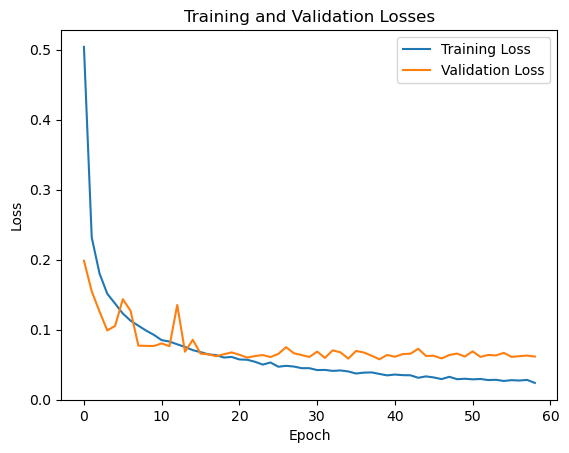

Validation Accuracy: 0.9863


In [29]:
# Define the FCN model with dropout and early stopping
class FCNWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(FCNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='.', train=False, transform=transform)

# Set the hyperparameters
input_size = 28 * 28  # input images of size 28x28
hidden_size = 256  # Number of units in the hidden layers
output_size = 10  # Number of output classes (for classification)
learning_rate = 0.1
dropout_rate = 0.3  # Dropout rate

# Initialize the model
model = FCNWithDropout(input_size, hidden_size, output_size, dropout_rate)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define early stopping parameters
max_epochs = 70
patience = 20
best_val_loss = float('inf')
no_improvement_count = 0
best_model_state = None

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch + 1}/{max_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Check for early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
        best_model_state = model.state_dict()
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f"No improvement for {patience} epochs. Early stopping...")
        break

# Load the best model state
model.load_state_dict(best_model_state)

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch [1/70], Train Loss: 0.4707, Val Loss: 0.2585
Epoch [2/70], Train Loss: 0.2064, Val Loss: 0.1635
Epoch [3/70], Train Loss: 0.1587, Val Loss: 0.1461
Epoch [4/70], Train Loss: 0.1310, Val Loss: 0.0895
Epoch [5/70], Train Loss: 0.1156, Val Loss: 0.1001
Epoch [6/70], Train Loss: 0.1027, Val Loss: 0.0938
Epoch [7/70], Train Loss: 0.0896, Val Loss: 0.0827
Epoch [8/70], Train Loss: 0.0825, Val Loss: 0.0842
Epoch [9/70], Train Loss: 0.0759, Val Loss: 0.0699
Epoch [10/70], Train Loss: 0.0722, Val Loss: 0.0694
Epoch [11/70], Train Loss: 0.0650, Val Loss: 0.0696
Epoch [12/70], Train Loss: 0.0628, Val Loss: 0.0678
Epoch [13/70], Train Loss: 0.0569, Val Loss: 0.0690
Epoch [14/70], Train Loss: 0.0529, Val Loss: 0.0601
Epoch [15/70], Train Loss: 0.0522, Val Loss: 0.0662
Epoch [16/70], Train Loss: 0.0461, Val Loss: 0.0625
Epoch [17/70], Train Loss: 0.0456, Val Loss: 0.0637
Epoch [18/70], Train Loss: 0.0440, Val Loss: 0.0615
Epoch [19/70], Train Loss: 0.0413, Val Loss: 0.0737
Epoch [20/70], Train 

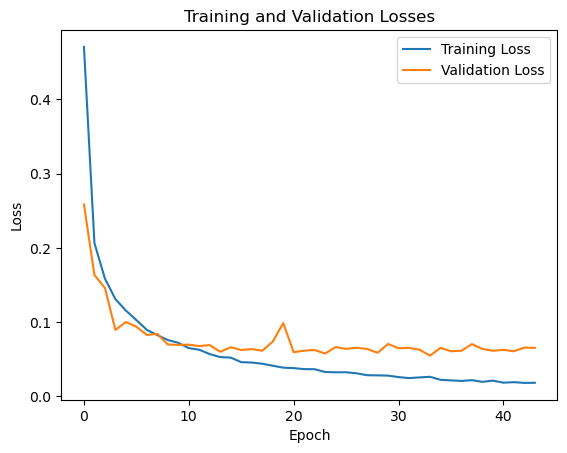

Validation Accuracy: 0.9844


In [30]:
# Define the FCN model with dropout and early stopping
class FCNWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(FCNWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=transform)
val_dataset = torchvision.datasets.MNIST(root='.', train=False, transform=transform)

# Set the hyperparameters
input_size = 28 * 28  # input images of size 28x28
hidden_size = 256  # Number of units in the hidden layers
output_size = 10  # Number of output classes (for classification)
learning_rate = 0.1
dropout_rate = 0.2  # Dropout rate

# Initialize the model
model = FCNWithDropout(input_size, hidden_size, output_size, dropout_rate)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define early stopping parameters
max_epochs = 70
patience = 10
best_val_loss = float('inf')
no_improvement_count = 0
best_model_state = None

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(max_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)

    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)

    epoch_val_loss = running_val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch + 1}/{max_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Check for early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
        best_model_state = model.state_dict()
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f"No improvement for {patience} epochs. Early stopping...")
        break

# Load the best model state
model.load_state_dict(best_model_state)

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

# Evaluate the model on the test set
I chose the last model I tried before the overfitting prevention experiments

In [5]:
# Define the SimpleNN model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Lists to store training and test losses
train_losses = []
test_losses = []

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Evaluate the model on the test set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
    epoch_test_loss = running_test_loss / len(test_dataset)
    test_losses.append(epoch_test_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

# Evaluate the final model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Epoch [1/50], Train Loss: 0.4208, Test Loss: 0.3239
Epoch [2/50], Train Loss: 0.1635, Test Loss: 0.1333
Epoch [3/50], Train Loss: 0.1165, Test Loss: 0.1030
Epoch [4/50], Train Loss: 0.0905, Test Loss: 0.0853
Epoch [5/50], Train Loss: 0.0737, Test Loss: 0.0907
Epoch [6/50], Train Loss: 0.0618, Test Loss: 0.0798
Epoch [7/50], Train Loss: 0.0542, Test Loss: 0.0961
Epoch [8/50], Train Loss: 0.0457, Test Loss: 0.0677
Epoch [9/50], Train Loss: 0.0374, Test Loss: 0.0853
Epoch [10/50], Train Loss: 0.0349, Test Loss: 0.0788
Epoch [11/50], Train Loss: 0.0298, Test Loss: 0.0656
Epoch [12/50], Train Loss: 0.0261, Test Loss: 0.0884
Epoch [13/50], Train Loss: 0.0216, Test Loss: 0.0666
Epoch [14/50], Train Loss: 0.0202, Test Loss: 0.0766
Epoch [15/50], Train Loss: 0.0173, Test Loss: 0.0692
Epoch [16/50], Train Loss: 0.0128, Test Loss: 0.0644
Epoch [17/50], Train Loss: 0.0128, Test Loss: 0.0771
Epoch [18/50], Train Loss: 0.0104, Test Loss: 0.0741
Epoch [19/50], Train Loss: 0.0081, Test Loss: 0.0698
Ep

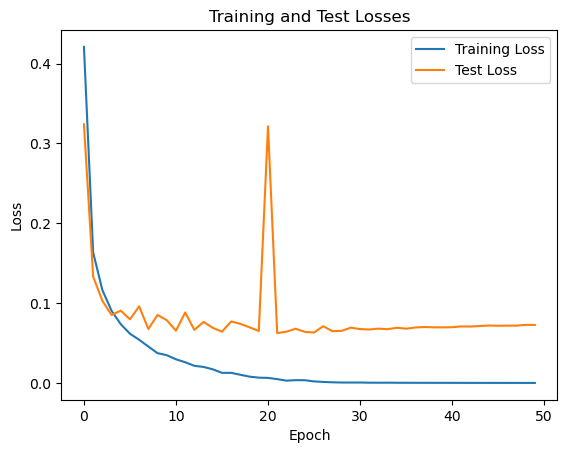

In [6]:
# Plot the training and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

### Overfitting has occurred - I will try to handle it with the methods I tried before

In [8]:
# Define the SimpleNN model with dropout
class SimpleNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize the model with dropout
model = SimpleNN(dropout_rate=0.3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Lists to store training and test losses
train_losses = []
test_losses = []

# Define early stopping parameters
patience = 15
best_test_loss = float('inf')
no_improvement_count = 0

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Evaluate the model on the test set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
    epoch_test_loss = running_test_loss / len(test_dataset)
    test_losses.append(epoch_test_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

    # Check for early stopping
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f"No improvement for {patience} epochs. Early stopping...")
        break

# Evaluate the final model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Epoch [1/50], Train Loss: 0.5045, Test Loss: 0.2383
Epoch [2/50], Train Loss: 0.2319, Test Loss: 0.1307
Epoch [3/50], Train Loss: 0.1799, Test Loss: 0.1451
Epoch [4/50], Train Loss: 0.1562, Test Loss: 0.1125
Epoch [5/50], Train Loss: 0.1345, Test Loss: 0.0900
Epoch [6/50], Train Loss: 0.1233, Test Loss: 0.1360
Epoch [7/50], Train Loss: 0.1124, Test Loss: 0.0843
Epoch [8/50], Train Loss: 0.1013, Test Loss: 0.0814
Epoch [9/50], Train Loss: 0.0965, Test Loss: 0.0741
Epoch [10/50], Train Loss: 0.0909, Test Loss: 0.0751
Epoch [11/50], Train Loss: 0.0848, Test Loss: 0.0800
Epoch [12/50], Train Loss: 0.0802, Test Loss: 0.0899
Epoch [13/50], Train Loss: 0.0772, Test Loss: 0.0737
Epoch [14/50], Train Loss: 0.0739, Test Loss: 0.0665
Epoch [15/50], Train Loss: 0.0700, Test Loss: 0.0679
Epoch [16/50], Train Loss: 0.0669, Test Loss: 0.0749
Epoch [17/50], Train Loss: 0.0660, Test Loss: 0.0711
Epoch [18/50], Train Loss: 0.0607, Test Loss: 0.0742
Epoch [19/50], Train Loss: 0.0605, Test Loss: 0.0619
Ep

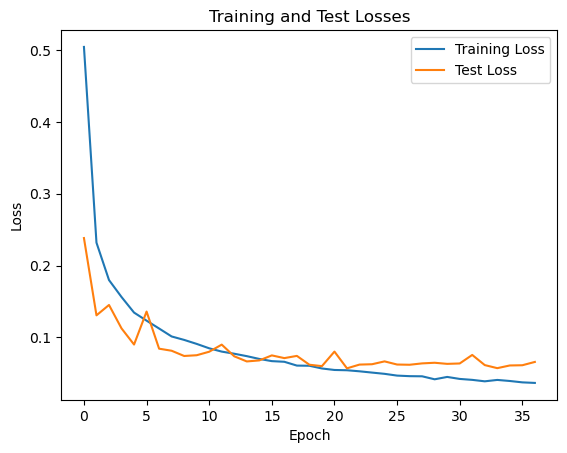

In [9]:
# Plot the training and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

### There is a significant improvement but I want to try to improve even more

In [10]:
# Define the SimpleNN model with dropout
class SimpleNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize the model with dropout
model = SimpleNN(dropout_rate=0.3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Lists to store training and test losses
train_losses = []
test_losses = []

# Define early stopping parameters
patience = 10
best_test_loss = float('inf')
no_improvement_count = 0

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Evaluate the model on the test set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
    epoch_test_loss = running_test_loss / len(test_dataset)
    test_losses.append(epoch_test_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

    # Check for early stopping
    if epoch_test_loss < best_test_loss:
        best_test_loss = epoch_test_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f"No improvement for {patience} epochs. Early stopping...")
        break

# Evaluate the final model on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Epoch [1/50], Train Loss: 0.5039, Test Loss: 0.2417
Epoch [2/50], Train Loss: 0.2337, Test Loss: 0.1470
Epoch [3/50], Train Loss: 0.1812, Test Loss: 0.1631
Epoch [4/50], Train Loss: 0.1547, Test Loss: 0.1080
Epoch [5/50], Train Loss: 0.1361, Test Loss: 0.0963
Epoch [6/50], Train Loss: 0.1237, Test Loss: 0.0903
Epoch [7/50], Train Loss: 0.1131, Test Loss: 0.0806
Epoch [8/50], Train Loss: 0.1056, Test Loss: 0.1102
Epoch [9/50], Train Loss: 0.0987, Test Loss: 0.0838
Epoch [10/50], Train Loss: 0.0900, Test Loss: 0.0771
Epoch [11/50], Train Loss: 0.0878, Test Loss: 0.0700
Epoch [12/50], Train Loss: 0.0835, Test Loss: 0.0687
Epoch [13/50], Train Loss: 0.0774, Test Loss: 0.0951
Epoch [14/50], Train Loss: 0.0751, Test Loss: 0.0694
Epoch [15/50], Train Loss: 0.0724, Test Loss: 0.0676
Epoch [16/50], Train Loss: 0.0679, Test Loss: 0.0636
Epoch [17/50], Train Loss: 0.0665, Test Loss: 0.0690
Epoch [18/50], Train Loss: 0.0637, Test Loss: 0.0728
Epoch [19/50], Train Loss: 0.0617, Test Loss: 0.0642
Ep

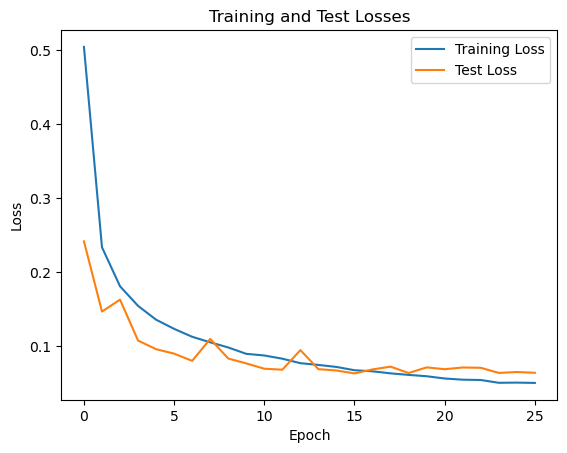

In [11]:
# Plot the training and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()

### I arrived at a model that satisfies me in terms of performance and I was also able to prevent the overfitting that was there